In [1]:
%pylab inline
from partFive import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
NN = NeuralNetwork()

In [3]:
# X = (hours sleeping, hours studying), y = Score on test
X = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
y = np.array(([75], [82], [93], [70]), dtype=float)

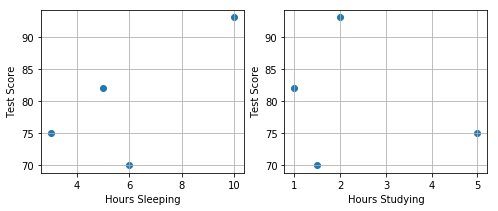

In [4]:
#Plot projections of our new data:
fig = figure(0,(8,3))

subplot(1,2,1)
scatter(X[:,0], y)
grid(1)
xlabel('Hours Sleeping')
ylabel('Test Score')

subplot(1,2,2)
scatter(X[:,1], y)
grid(1)
xlabel('Hours Studying')
ylabel('Test Score')

In [5]:
#Normalize
X = X/np.amax(X, axis=0)
y = y/100 #Max test score is 100

In [6]:
#Train network with new data:
T = trainer(NN)
T.train(X,y)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 188
         Function evaluations: 212
         Gradient evaluations: 212


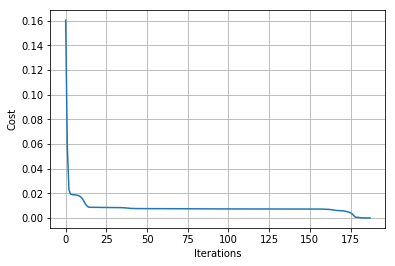

In [7]:
#Plot cost during training:
plot(T.J)
grid(1)
xlabel('Iterations')
ylabel('Cost')

In [8]:
#Test network for various combinations of sleep/study:
hoursSleep = linspace(0, 10, 100)
hoursStudy = linspace(0, 5, 100)

#Normalize data (same way training data way normalized)
hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

#Create 2-d versions of input for plotting
a, b  = meshgrid(hoursSleepNorm, hoursStudyNorm)

#Join into a single input matrix:
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

In [9]:
allOutputs = NN.forward(allInputs)

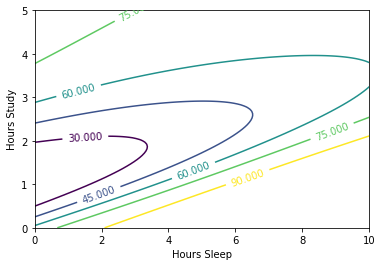

In [12]:
#Contour Plot:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = contour(xx,yy,100*allOutputs.reshape(100, 100))
clabel(CS, inline=1, fontsize=10)
xlabel('Hours Sleep')
ylabel('Hours Study')

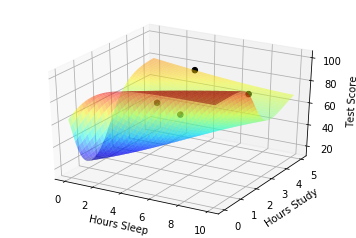

In [13]:
#3D plot:
#Uncomment to plot out-of-notebook (you'll be able to rotate)
#%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

#Scatter training examples:
ax.scatter(10*X[:,0], 5*X[:,1], 100*y, c='k', alpha = 1, s=30)


surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=cm.jet, alpha = 0.5)


ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

So it appears our model is overfitting, but how do we know for sure? A widely accepted method is to split our data into 2 portions: training and testing. We won’t touch our testing data while training the model, and only use it to see how we’re doing – our testing data is a simulation of the real world. We can plot the error on our training and testing sets as we train our model and identify the exact point at which overfitting begins. We can also plot testing and training error as a function of model complexity a see similar behavior.

In [14]:
#Training Data:
trainX = np.array(([3,5], [5,1], [10,2], [6,1.5]), dtype=float)
trainY = np.array(([75], [82], [93], [70]), dtype=float)

#Testing Data:
testX = np.array(([4, 5.5], [4.5,1], [9,2.5], [6, 2]), dtype=float)
testY = np.array(([70], [89], [85], [75]), dtype=float)

#Normalize:
trainX = trainX/np.amax(trainX, axis=0)
trainY = trainY/100 #Max test score is 100

#Normalize by max of training data:
testX = testX/np.amax(trainX, axis=0)
testY = testY/100 #Max test score is 100

In [15]:
##Need to modify trainer class a bit to check testing error during training:
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))
        self.testJ.append(self.N.costFunction(self.testX, self.testY))
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, trainX, trainY, testX, testY):
        #Make an internal variable for the callback function:
        self.X = trainX
        self.y = trainY
        
        self.testX = testX
        self.testY = testY

        #Make empty list to store training costs:
        self.J = []
        self.testJ = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(trainX, trainY), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res

In [16]:
#Train network with new data:
NN = NeuralNetwork()

T = trainer(NN)
T.train(trainX, trainY, testX, testY)

         Current function value: 0.004132
         Iterations: 200
         Function evaluations: 233
         Gradient evaluations: 233


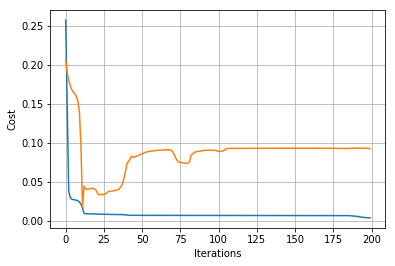

In [17]:
#Plot cost during training:
plot(T.J)
plot(T.testJ)
grid(1)
xlabel('Iterations')
ylabel('Cost')

So now that we know overfitting is a problem, but how do we fix it? One way is to throw more data at the problem. A simple rule of thumb as presented by Yaser Abu-Mostaf is his excellent machine learning course available from Caltech, is that you should have at least 10 times as many examples as the degrees for freedom in your model. For us, since we have 9 weights that can change, we would need 90 observations, which we certainly don’t have.
Link to course: https://work.caltech.edu/telecourse.html
Another popular and effective way to mitigate overfitting is to use a technique called regularization. One way to implement regularization is to add a term to our cost function that penalizes overly complex models. A simple, but effective way to do this is to add together the square of our weights to our cost function, this way, models with larger magnitudes of weights, cost more. We’ll need to normalize the other part of our cost function to ensure that our ratio of the two error terms does not change with respect to the number of examples. We’ll introduce a regularization hyper parameter, lambda, that will allow us to tune the relative cost – higher values of lambda will impose bigger penalties for high model complexity.

In [40]:
#Regularization Parameter:
Lambda = 0.0005

In [41]:
#Need to make changes to costFunction and costFunctionPrim:
def costFunction(self, X, y):
    #Compute cost for given X,y, use weights already stored in class.
    self.yHat = self.forward(X)
    #We don't want cost to increase with the number of examples, so normalize by dividing the error term by number of examples(X.shape[0])
    J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(sum(self.W1**2)+sum(self.W2**2))
    return J

def costFunctionPrime(self, X, y):
    #Compute derivative with respect to W and W2 for a given X and y:
    self.yHat = self.forward(X)

    delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
    #Add gradient of regularization term:
    dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2

    delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
    #Add gradient of regularization term:
    dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1

    return dJdW1, dJdW2

In [42]:
#New complete class, with changes:
class NewNeuralNetwork(object):
    def __init__(self, Lambda=0):        
        #Define Hyperparameters
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize)
        self.W2 = np.random.randn(self.hiddenLayerSize,self.outputLayerSize)
        
        #Regularization Parameter:
        self.Lambda = Lambda
        
    def forward(self, X):
        #Propogate inputs though network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        yHat = self.sigmoid(self.z3) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(np.sum(self.W1**2)+np.sum(self.W2**2))
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta3 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z3))
        #Add gradient of regularization term:
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        #Add gradient of regularization term:
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1
        
        return dJdW1, dJdW2
    
    #Helper functions for interacting with other methods/classes
    def getParams(self):
        #Get W1 and W2 Rolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single parameter vector:
        W1_start = 0
        W1_end = self.hiddenLayerSize*self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], \
                             (self.inputLayerSize, self.hiddenLayerSize))
        W2_end = W1_end + self.hiddenLayerSize*self.outputLayerSize
        self.W2 = np.reshape(params[W1_end:W2_end], \
                             (self.hiddenLayerSize, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel()))

In [51]:
NN = NewNeuralNetwork(Lambda=0.0009)#Make sure our gradients our correct after making changes:

In [52]:
numgrad = computeNumericalGradient(NN, X, y)
grad = NN.computeGradients(X,y)

In [53]:
#Should be less than 1e-8:
norm(grad-numgrad)/norm(grad+numgrad)

1.8892268000361654e-10

In [54]:
T = trainer(NN)

In [55]:
T.train(X,y,testX,testY)

Optimization terminated successfully.
         Current function value: 0.004234
         Iterations: 56
         Function evaluations: 59
         Gradient evaluations: 59


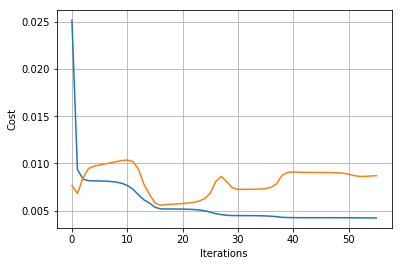

In [56]:
plot(T.J)
plot(T.testJ)
grid(1)
xlabel('Iterations')
ylabel('Cost')

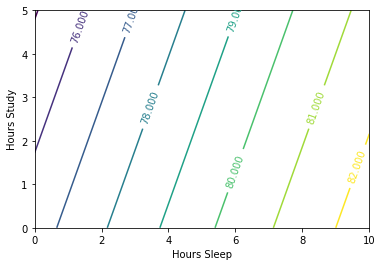

In [49]:
allOutputs = NN.forward(allInputs)

#Contour Plot:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = contour(xx,yy,100*allOutputs.reshape(100, 100))
clabel(CS, inline=1, fontsize=10)
xlabel('Hours Sleep')
ylabel('Hours Study')

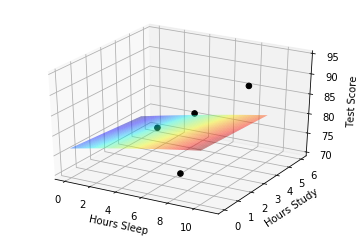

In [50]:
#3D plot:

##Uncomment to plot out-of-notebook (you'll be able to rotate)
#%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.scatter(11*X[:,0], 6*X[:,1], 101*y, c='k', alpha = 1, s=31)


surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=cm.jet, alpha = 0.5)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')